In [7]:
import torch
from torch import optim
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from gan import models, build_gan_trainer, kl_gan_loss_step
from utils.benchmark import train
from utils.display import display_images
from utils.checkpoints import load_checkpoint
from __datasets__ import CelebADataset

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
config_dc_gan = models.DCGanConfig(
    "CelebA",
    writer=True,
    lr=2e-4,
    p=0,
    hidden_channels=64,
    out_channels=3,
    sampling_layers=5,
    blocks=(64, 128, 256, 512),
)
config_dc_gan

DCGanConfig(model_name='CelebA', model_version='v1', model_dir='./models/', log_dir='./logs/', device='mps', writer=<torch.utils.tensorboard.writer.SummaryWriter object at 0x169442050>, n=1, p=0, sampling_layers=5, lr=0.0002, betas=(0.5, 0.999), blocks=(64, 128, 256, 512), latent_dim=128, out_channels=3, hidden_channels=64, head_kernel=4, head_stride=1, head_padding=0)

In [9]:
ds = CelebADataset(DIR="../../pytorch/datasets/celeb-a", download=True, sub_sample=0.2,
                   image_transform=T.Compose([
                       T.Resize((64, 64)),
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       lambda x: x.to(config_dc_gan.device),
                   ]))
len(ds), type(ds[0:1])

(40519, dict)

In [10]:
generator, discriminator = models.build_DCGan(config_dc_gan)
optimizerG = optim.Adam(generator.parameters(), lr=config_dc_gan.lr, betas=config_dc_gan.betas)
optimizerD = optim.Adam(discriminator.parameters(), lr=config_dc_gan.lr, betas=config_dc_gan.betas)

In [12]:
if input("Load Model[y|n]?> ").lower() == "y":
    others = load_checkpoint(
        input("path?> "),
        {"generator": generator, "discriminator": discriminator},
        {"generator": optimizerG, "discriminator": optimizerD},
    )
    step_offset = others["step"]
else:
    step_offset = 0
step_offset

15000

In [13]:
def data_extractor(DATA):
    real = DATA["image"]
    noise = generator.sample_noise(real.shape[0], device=config_dc_gan.device)
    return real, noise

fixed_inp = generator.sample_noise(9 * 9, device=config_dc_gan.device)
trainer = build_gan_trainer(
    generator, discriminator,
    optimizerG, optimizerD,
    kl_gan_loss_step, data_extractor,
    save_path=None, save_period=500,
    writer=config_dc_gan.writer, writer_period=200, fixed_inp=fixed_inp,
    perceptual_loss=False,
    device=config_dc_gan.device,
)

In [14]:
print(generator, end="\n\n")
print(discriminator, end="\n\n")
print((fake := generator(fixed_inp)).cpu().shape, discriminator(fake).shape)

DCGenerator(
  (head): ConvBlock(
    (layers): ModuleList(
      (0): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(1, 1))
      (1): ReLU()
    )
  )
  (blocks): Sequential(
    (0): ConvBlock(
      (layers): ModuleList(
        (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (layers): ModuleList(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
      )
    )
    (2): ConvBlock(
      (layers): ModuleList(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fal

In [22]:
generator = generator.train()
discriminator = discriminator.train()
step_offset = train(
    trainer, ds,
    ne=4, bs=16,
    step_offset=step_offset + 1,
)
step_offset

Epoch: 0/4 | Batch 0/2533|          |  0% [00:00<?, ?it/s ]

KeyboardInterrupt: 

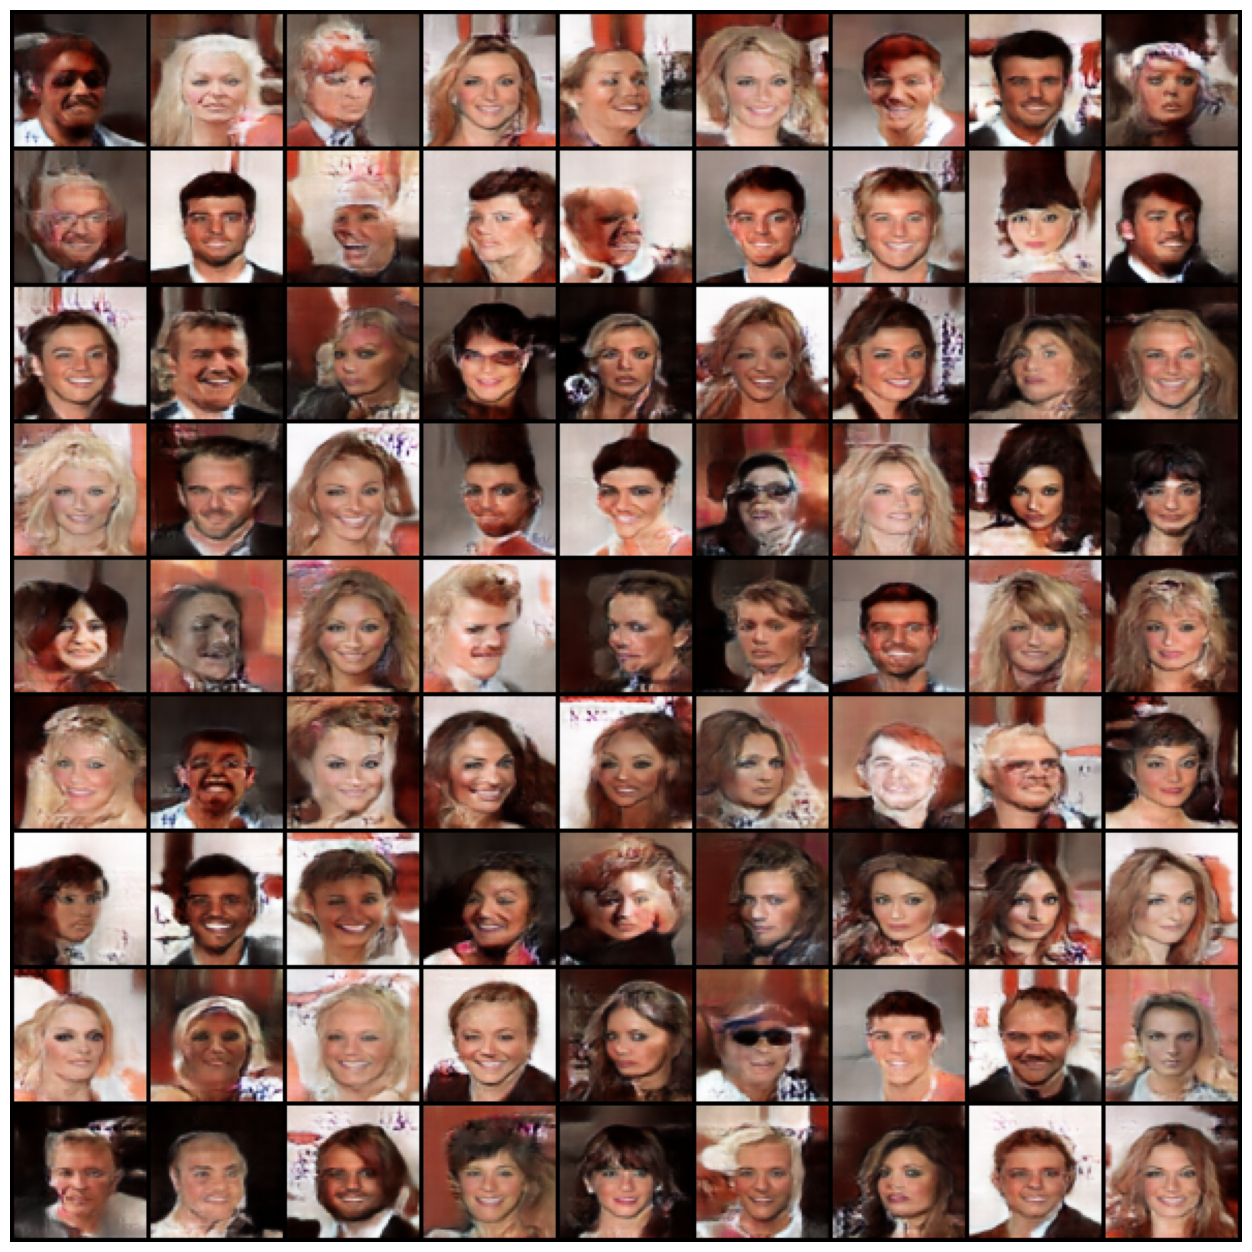

CPU times: user 1.45 s, sys: 175 ms, total: 1.62 s
Wall time: 2.73 s


In [16]:
%%time

generator = generator.eval()
discriminator = discriminator.eval()
with torch.inference_mode():
    fake = generator(generator.sample_noise(9 * 9, device=config_dc_gan.device))
    grid_fake = make_grid(fake, nrow=9, normalize=True)
display_images(torch.stack([grid_fake]).cpu().permute(0, 2, 3, 1))

In [26]:
save_image(grid_fake, "grid_fake.png")